In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet50_Weights

In [2]:
import random

class ImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, device="cpu"):
        super().__init__()
        self.images_dir = image_dir
        self.annotations_dir = annotation_dir
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, index):
        image_1 = Image.open(self.images_dir[index]).convert('RGB')
        bbox_1, label_1 = self.parse_annotation(self.annotations_dir[index])
        
        idx_2 = random.randint(0, len(self.images_dir) - 1)
        image_2 = Image.open(self.images_dir[idx_2]).convert('RGB')
        bbox_2, label_2 = self.parse_annotation(self.annotations_dir[index])

        # Horizantal merge
        merge_image = Image.new(
            "RGB", (image_1.width + image_2.width, max(image_1.height, image_2.height))
        )

        merge_image.paste(image_1, (0,0))
        merge_image.paste(image_2, (image_1.width, 0))
        merge_img_w = image_1.width + image_2.width
        merge_img_h = max(image_1.height, image_2.height)

        merged_annotation = []

        #No change for obj from img1, already normalize
        merged_annotation.append(
            torch.cat((bbox_1.to(self.device), torch.tensor(
                [label_1], device=self.device)), dim=0)
        )
        
        # re-normalize về dạng thường, rồi normalize lại cho đúng dạng merge
        bbox_2[0] = (bbox_2[0] * image_2.width + image_1.width) / merge_img_w
        bbox_2[1] = (bbox_2[1] * image_2.height + image_1.height) / merge_img_h
        bbox_2[2] = (bbox_2[2] * image_2.width + image_1.width) / merge_img_w
        bbox_2[3] = (bbox_2[3] * image_2.height + image_1.height) / merge_img_h

        merged_annotation.append(
            torch.cat((bbox_2.to(self.device), torch.tensor(
                [label_2], device=self.device)), dim=0)
        )

        if self.transform != None:
            merge_image = self.transform(merge_image)
        else:
            merge_image = transforms.ToTensor()(merge_image)
            
        annotations = torch.stack(merged_annotation)

        # lưu ý khi return buộc phải ở dạng tensor
        return merge_image.to(device=self.device), annotations

    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        # Khởi tạo label
        label = None
        bbox = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:
                label = name

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            # Normalize bbox coordinates to [0, 1]
            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height,
            ]

        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return bbox_tensor, label_num

In [3]:
def get_count_filename_obj(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    count = 0

    for obj in root.findall('object'):
        count += 1
    return count


def filter_images_with_multiple_obj(images_path, annotations_paths):
        valid_img_paths = []
        valid_img_annotation_paths = []
        for index, annotation_path in enumerate(annotations_paths):
            count = get_count_filename_obj(annotation_path)
            if count <= 1:
                valid_img_paths.append(images_path[index])
                valid_img_annotation_paths.append(annotations_paths[index])
            else:
                print(
                    f"Image {images_path[index]} has multiple objects and will be excluded from the dataset")

        print(f"Total has {len(valid_img_paths)} valid image")

        return valid_img_paths, valid_img_annotation_paths

In [4]:
# Data directory
annotations_dir = '/kaggle/input/dog-and-cat-detection/annotations'
image_dir = '/kaggle/input/dog-and-cat-detection/images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(
    image_dir) if os.path.isfile(os.path.join(image_dir, f))]
annotations_files = [os.path.join(annotations_dir, f) for f in os.listdir(
    annotations_dir) if os.path.isfile(os.path.join(annotations_dir, f))]

# filter image > 1 obj

image_files, annotations_files = filter_images_with_multiple_obj(image_files, annotations_files)

x_train, x_val, y_train, y_val = train_test_split(
    image_files, annotations_files, test_size=0.2, random_state=42)

# Output the result
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))

y_train[0]

Image /kaggle/input/dog-and-cat-detection/images/Cats_Test1747.png has multiple objects and will be excluded from the dataset
Total has 3685 valid image
Training set size: 2948
Validation set size: 737


'/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1919.xml'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(x_train, y_train, transform=transform, device=device)
val_dataset = ImageDataset(x_val, y_val, transform=transform, device=device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

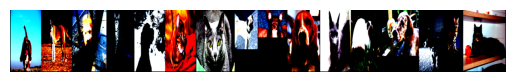

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Hàm để hiển thị hình ảnh
def imshow(img):
    np_img = img.cpu().numpy() 
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Chuyển đổi định dạng thành HWC
    plt.axis('off')  
    plt.show()


# Lấy một batch từ train_loader và hiển thị ảnh
for i, (merge_image, merged_annotation) in enumerate(train_loader, 0):
    # Hiển thị 8 ảnh đầu tiên
    imshow(torchvision.utils.make_grid(merge_image[:8]))
    break  # Thoát khỏi vòng lặp sau batch đầu tiên

### Xây dựng model

In [7]:
# last_layer = list(models.resnet50(
#     weights=ResNet50_Weights.DEFAULT).children())[:-2]
# print(last_layer)

In [8]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        self.backbone = nn.Sequential(*list(self.backbone.children()))[:-2]
        self.classifier = nn.Linear(2048, (2 * 2 * (4 + self.num_classes)))

        
    def forward(self, x):
        features = self.backbone(x)
        features = nn.AdaptiveAvgPool2d((1, 1))(features) #(B, 2048, 1, 1)
        features = nn.Flatten(1)(features)
        output = self.classifier(features)
        return output


### Cài đặt model

In [9]:
# # Initialize model, criterion, and optimizer
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_classes = 2  # Assuming two classes: dog and cat
# class_to_idx = {'dog': 0, 'cat': 1}

# model = SimpleYOLO(num_classes=num_classes).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# model

In [10]:
# import torch

# # Giả lập batch đầu vào
# batch_size = 1
# channels = 3
# height, width = 224, 224  # Kích thước ảnh đầu vào

# # Tạo tensor đầu vào giả
# dummy_input = torch.randn(batch_size, channels, height, width).to(device)

# # Chạy mô hình
# output = model(dummy_input)

# # Kiểm tra kích thước đầu ra
# print("Output shape:", output.shape)

- **Tọa độ chuẩn hóa** `(0.3, 0.8)` chỉ là giá trị tương đối trong toàn bộ ảnh.
- **Nhân với số ô `2`** (trục `x` và `y`) để tìm đúng ô lưới tương ứng:
  - $0.3 \times 2 = 0.6 \rightarrow \text{int}(0.6) = 0$
  - $0.8 \times 2 = 1.6 \rightarrow \text{int}(1.6) = 1$
- Nếu không nhân, bạn sẽ không biết chính xác bounding box thuộc ô nào trong lưới.

In [11]:
def calculate_loss(outputs, targets, num_classes, device):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    total_loss = 0
    batch_size = outputs.size()[0]
    outputs = outputs.view(batch_size, 2, 2, 4 + num_classes)  # (b, h, w, c)
    for i in range(batch_size):
        for obj_idx in range(len(targets[i])):

            # !!! chỉ tính loss cho ô xác định là có obj
            # (xmin + xmax) / 2
            x_center = (targets[i][obj_idx][0] + targets[i][obj_idx][2]) / 2
            y_center = (targets[i][obj_idx][1] + targets[i][obj_idx][3]) / 2
            
            # grid_size = 2x2
            id_grid_x = min(max(int(x_center * 2), 0), 1)
            id_grid_y = min(max(int(y_center * 2), 0), 1)

            bbox_target = targets[i][obj_idx][:4]
            regression_loss = mse_loss(
                outputs[i][id_grid_y][id_grid_x][: 4], bbox_target)

            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][obj_idx][4])] = 1
            classifier_loss = ce_loss(
                outputs[i, id_grid_y, id_grid_x, 4:], label_one_hot)

            # No object Loss : chỉ tính loss cho ô xác định là không có obj
            no_obj_loss = 0
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != id_grid_y or other_grid_x != id_grid_x:
                        # những ô không chưa obj thì mini về 0 là được
                        no_obj_loss += mse_loss(outputs[i, other_grid_y, other_grid_x, :4], torch.zeros(4, device=device))

            total_loss += regression_loss + classifier_loss + no_obj_loss

    return total_loss / batch_size  # Average loss over the batch

# Tạo dữ liệu giả để test
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_classes = 3
# batch_size = 2

# # Outputs của mô hình (logits)
# outputs = torch.randn(batch_size, 2, 2, 4 + num_classes, device=device)

# # Targets (bounding boxes + labels)
# # Format: [xmin, ymin, xmax, ymax, class_idx]
# targets = [
#     torch.tensor([[0.1, 0.2, 0.3, 0.4, 0], [
#                  0.5, 0.6, 0.7, 0.8, 1]], device=device),
#     torch.tensor([[0.2, 0.3, 0.4, 0.5, 2]], device=device)
# ]

# # Gọi hàm tính loss
# loss = calculate_loss(outputs, targets, num_classes, device)
# print(f"Loss: {loss.item()}")

In [12]:
import matplotlib.pyplot as plt
import tqdm
import time
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)
        
            total_loss = calculate_loss(outputs, targets, num_classes, device)
            running_loss += total_loss.item()

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            outputs = outputs.view(images.shape[0], 2, 2, 4 + num_classes)

            for batch_idx in range(images.shape[0]):
                for obj in targets[batch_idx]:
                    x_center = (obj[0] + obj[2]) / 2
                    y_center = (obj[1] + obj[3]) / 2

                    # grid_size = 2x2
                    id_grid_x = min(max(int(x_center * 2), 0), 1)
                    id_grid_y = min(max(int(y_center * 2), 0), 1)

                    # kh cần đẩy qua softmax, ví số đã lớn đẩy qua softmax nó cx lớn và lấy max
                    prediction = outputs[batch_idx, id_grid_y, id_grid_x, 4:].argmax().item()
                    all_predictions.append(prediction)
                    all_targets.append(obj[4].item())
    
    val_losses = running_loss / images.shape[0]
    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    val_accuracies = (all_predictions == all_targets).float().mean()
    return val_losses, val_accuracies.item()
        

def train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
):
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            total_loss = calculate_loss(outputs, targets, num_classes, device)

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_accuracy = evaluate_model(
            model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}"
        )

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # Assuming two classes: dog and cat
class_to_idx = {'dog': 0, 'cat': 1}
num_epochs = 50
model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


Epoch 1/50, Train Loss: 2.0348, Validation Loss: 49.1052, Validation Accuracy: 0.6825
Epoch 2/50, Train Loss: 2.0088, Validation Loss: 49.2523, Validation Accuracy: 0.6825
Epoch 3/50, Train Loss: 2.0052, Validation Loss: 49.4801, Validation Accuracy: 0.6825
Epoch 4/50, Train Loss: 1.9931, Validation Loss: 48.8693, Validation Accuracy: 0.6825
Epoch 5/50, Train Loss: 1.9905, Validation Loss: 48.8253, Validation Accuracy: 0.6818
Epoch 6/50, Train Loss: 1.9956, Validation Loss: 48.6791, Validation Accuracy: 0.6825
Epoch 7/50, Train Loss: 1.9702, Validation Loss: 49.5665, Validation Accuracy: 0.6825
Epoch 8/50, Train Loss: 1.9899, Validation Loss: 49.0289, Validation Accuracy: 0.6825
Epoch 9/50, Train Loss: 1.9855, Validation Loss: 49.4317, Validation Accuracy: 0.6825
Epoch 10/50, Train Loss: 1.9733, Validation Loss: 48.2334, Validation Accuracy: 0.6825
Epoch 11/50, Train Loss: 1.9749, Validation Loss: 48.5339, Validation Accuracy: 0.6825
Epoch 12/50, Train Loss: 1.9763, Validation Loss: 48

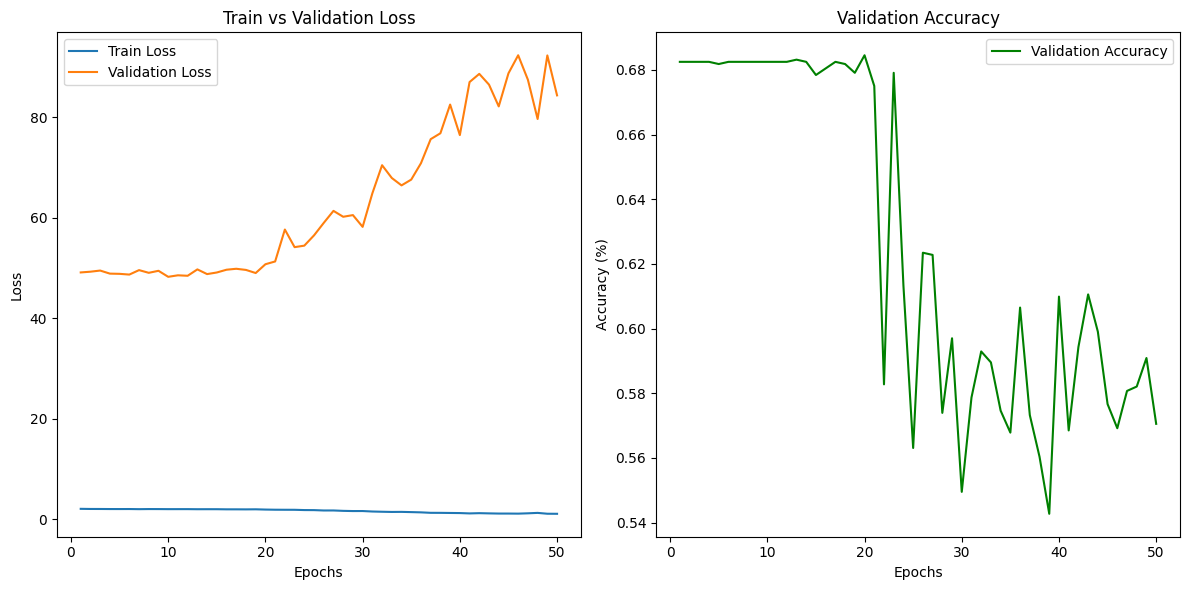

In [14]:
# Visualization
plt.figure(figsize=(12, 6))

# Loss Visualization
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy Visualization
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies,
         label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-15-72ab96eb145c>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


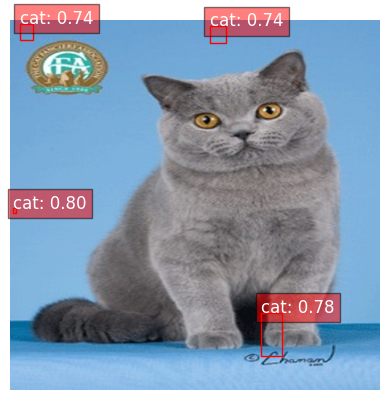

In [15]:
from matplotlib import patches

def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Resize the image to match the input size expected by the model (e.g., 448x448)
    resized_image = image.resize((448, 448))
    resized_width, resized_height = resized_image.size

    # Apply the same transformations used during training
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        output = output.view(1, 2, 2, 4 + len(class_to_idx)
                             )  # Reshape for 2x2 grid

        fig, ax = plt.subplots(1)
        ax.axis("off")
        ax.imshow(resized_image)  # Display resized image

        for grid_y in range(2):
            for grid_x in range(2):
                # Get the class prediction and bounding box for the current grid cell
                class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
                bbox = output[0, grid_y, grid_x, :4].tolist()  # Predicted bbox

                # Confidence (probability of the predicted class)
                confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[
                    class_pred
                ].item()

                # Scale the bounding box back to the resized image size
                # Assuming bbox coordinates are normalized to [0, 1] within the grid cell
                x_min = bbox[0] * (resized_width / 2) + \
                    grid_x * (resized_width / 2)
                y_min = bbox[1] * (resized_height / 2) + \
                    grid_y * (resized_height / 2)
                x_max = bbox[2] * (resized_width / 2) + \
                    grid_x * (resized_width / 2)
                y_max = bbox[3] * (resized_height / 2) + \
                    grid_y * (resized_height / 2)

                # Draw the bounding box and label on the image if confidence is above threshold
                if confidence > threshold:
                    rect = patches.Rectangle(
                        (x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth=1,
                        edgecolor="r",
                        facecolor="none",
                    )
                    ax.add_patch(rect)
                    plt.text(
                        x_min,
                        y_min,
                        f"{list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",
                        color="white",
                        fontsize=12,
                        bbox=dict(facecolor="red", alpha=0.5),
                    )

        plt.show()


# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Inference on a sample image
image_path = "/kaggle/input/dog-and-cat-detection/images/Cats_Test0.png"
inference(model, image_path, transform, device, class_to_idx, threshold=0.5)